In [111]:
import pandas as pd
from fbprophet import Prophet
from datetime import datetime
from fbprophet.plot import add_changepoints_to_plot
import matplotlib.pyplot as plt
import numpy as np


#input csv file 

df = pd.read_csv("precip.csv")
df.head()
print(df.tail())

df.columns=["ds","y"]
df.head()

         datetime  totalprecipmm
18622  2019-12-27            0.0
18623  2019-12-28            2.0
18624  2019-12-29           30.8
18625  2019-12-30            0.0
18626  2019-12-31            3.0


,ds,y
0,1969-01-01,0.0
1,1969-01-02,1.3
2,1969-01-03,0.5
3,1969-01-04,0.0
4,1969-01-05,6.4


In [108]:
df.set_index('ds')

,y
ds,
1969-01-01,0.0
1969-01-02,1.3
1969-01-03,0.5
1969-01-04,0.0
1969-01-05,6.4
...,...
2019-12-27,0.0
2019-12-28,2.0
2019-12-29,30.8


In [112]:
time = 3650*3+8

In [113]:
#Initializing
m = Prophet()
m.fit(df)

#prediction periods#
future = m.make_future_dataframe(periods=time)
future.tail()

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


,ds
29580,2049-12-27
29581,2049-12-28
29582,2049-12-29
29583,2049-12-30
29584,2049-12-31


In [114]:

##yearly seasonality#
m = Prophet(changepoint_prior_scale=30,weekly_seasonality=False,daily_seasonality=False,yearly_seasonality=True)
#m.add_seasonality(name='yearly', period=365, fourier_order=1)
forecast = m.fit(df).predict(future)

#prediction periods#
future = m.make_future_dataframe(periods=time)
future.tail()

forecast[["ds","yhat","yhat_lower","yhat_upper"]].tail()


,ds,yhat,yhat_lower,yhat_upper
29580,2049-12-27,2.684949,-27.890757,32.699387
29581,2049-12-28,2.676567,-29.903728,32.164140
29582,2049-12-29,2.668591,-28.828635,31.742268
29583,2049-12-30,2.661079,-30.407186,32.794952
29584,2049-12-31,2.654066,-30.279947,34.364300


In [48]:
##evaluate performance by monthly data

yhat = forecast[["ds","yhat"]]
yhat = yhat.set_index("ds")
precip_predict = yhat.resample('M').sum()
precip_predict.to_csv('precip_predict.csv')

df['ds'] = pd.to_datetime(df['ds'])
precip_test = df.set_index("ds").y.resample('M').sum()
precip_test.to_csv("precip_test.csv")

df1 = pd.read_csv("precip_predict.csv")
df2 = pd.read_csv("precip_test.csv")

df1.tail()
error= np.abs(df2["y"]-df1["yhat"][0:612])/df2["y"][0:612]
print(error)


0      0.249809
1      5.378253
2      0.509172
3      0.239409
4      0.226240
         ...   
607    2.669374
608    0.069791
609    0.337898
610    0.691717
611    0.472359
Length: 612, dtype: float64


In [52]:
#Evaluate performance by yearly data

precip_predict_y = yhat.resample('AS').sum()
precip_predict_y.to_csv('precip_predict1.csv')
precip_test_y = df.set_index("ds").y.resample('AS').sum()
precip_test_y.to_csv("precip_test1.csv")
df3 = pd.read_csv("precip_predict1.csv")
df4 = pd.read_csv("precip_test1.csv")

MAE = np.mean(np.abs(df4["y"]-df3["yhat"][0:50]))

MAPE = np.mean(np.abs(df4["y"]-df3["yhat"][0:50])/df4["y"][0:50])

print(MAPE,MAE)

0.11582150131750231 93.23196545356676


In [53]:
###evaluate performance by daily data

yhat = forecast[["ds","yhat"]]

def make_comparison_dataframe(historical, forecast):
    return forecast.set_index("ds")[["yhat"]].join(historical.set_index("ds"))

cmp_df = make_comparison_dataframe(df, yhat)[0:18626]

##define a function to calculate MAPE and MAE
def calculate_forecast_errors(df, prediction_size):
    
    df = df.copy()
    
    df["e"] = df["y"] - df["yhat"]
    df["p"] = 100 * df["e"] / df["y"]
    
    predicted_part = df[-prediction_size:]
    error_mean = lambda error_name:np.mean(np.abs(predicted_part[error_name]))
    return {"MAPE":error_mean('p'), "MAE": error_mean('e')}

prediction_size = 365*10  # 10 years prediction
calculate_forecast_errors(cmp_df, prediction_size)

{'MAPE': inf, 'MAE': 3.590105234776746}

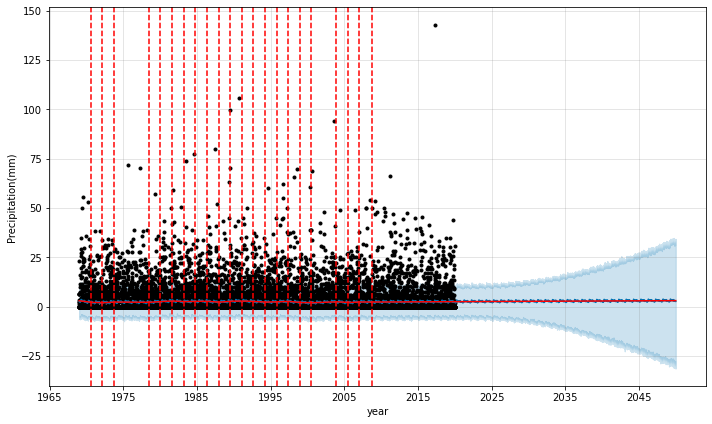

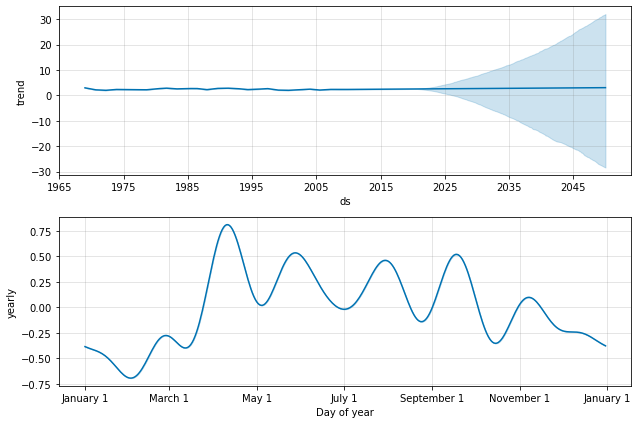

In [116]:
###Figure

fig = m.plot(forecast)
a = add_changepoints_to_plot(fig.gca(),m,forecast)
plt.xlabel("year")
plt.ylabel("Precipitation(mm)")
plt.savefig("preci.png")


fig = m.plot_components(forecast)